## Дерево решений

Задание
1. Построить геометрическую интерпретацию критерия Джини()
2. Применить дерево решений из sklearn для задачи Titanic на kaggle (заполнив пропуски).  
Применить кросс-валидацию для подбора параметров и выбрать лучшие(например с помощью **GridSearchCV** из sklearn).  
Написать отчет о результатах.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import optimize
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv', sep=',')
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
test = pd.read_csv('data/test.csv', sep=',')
test_targets = pd.read_csv('data/gender_submission.csv', sep=',')
test = test.assign(Survived = test_targets.Survived)
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1


In [4]:
print(f'train shape - {train.shape}')
print(f'test shape - {test.shape}')

train shape - (891, 12)
test shape - (418, 12)


## Бейзлайн Титаника 

In [5]:
features = ['Pclass', 'Age', 'SibSp',
       'Parch', 'Fare']

pipeline = Pipeline(steps = [('imputer', Imputer()),('scaler',StandardScaler()),('tree',DecisionTreeClassifier())])
grid = {
    'tree__criterion' : ['gini', 'entropy'],
    'tree__max_depth' : [2,5],  
}
gridsearch = GridSearchCV(pipeline, grid, cv = 3)     
gridsearch.fit(np.array(train.loc[:,features]), np.array(train.Survived))
gridsearch.best_estimator_

/home/gretchen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/gretchen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/gretchen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/gretchen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: Depre

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('tree', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=N...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [6]:
gridsearch.best_score_

0.712682379349046

In [7]:
accuracy_score(y_pred = gridsearch.predict(np.array(test[features])), y_true = test.Survived)

0.6746411483253588

## 1. Геометрическая интерпретация критерия Джини 

**Задание** Построить график кривой Лоренца (https://habr.com/ru/company/ods/blog/350440/ - абзац с машиным обучением) 
            для дерева решений с разделением по критерию Джини, используя бейзлайн.

**Пример**

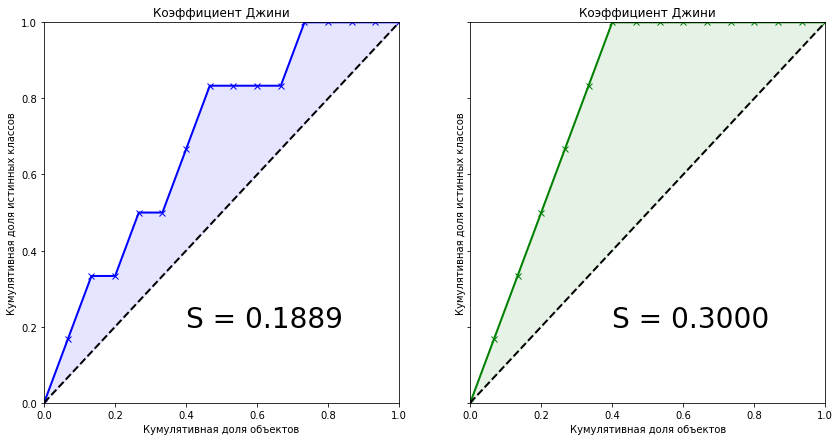

In [8]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

actual = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predict = [0.9, 0.3, 0.8, 0.75, 0.65, 0.6, 0.78, 0.7, 0.05, 0.4, 0.4, 0.05, 0.5, 0.1, 0.1]

data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)

x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)

f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=x_values)[0] - 0.5
S_actual = quad(f2, 0, 1, points=x_values)[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(14, 7))
ax[0].plot(x_values, y_values, lw = 2, color = 'blue', marker='x')
ax[0].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax[1].plot(x_values, y_values_perfect, lw = 2, color = 'green', marker='x')
ax[1].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.4f}'.format(S_actual),fontsize = 28)

for i in range(2):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();

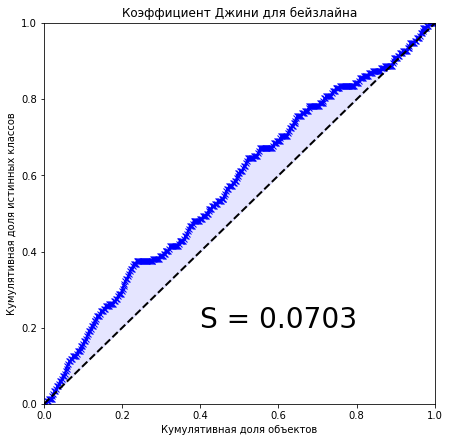

In [9]:
probs_pr = gridsearch.predict_proba(np.array(test[features]))
predict = [p[1] for p in probs_pr]
actual = test.Survived
data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)

x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)

f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=x_values, limit=500)[0] - 0.5
S_actual = quad(f2, 0, 1, points=x_values, limit=500)[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=1, sharey=True, figsize=(7, 7))
ax.plot(x_values, y_values, lw = 2, color = 'blue', marker='x')
ax.fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax.text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
ax.set(title='Коэффициент Джини для бейзлайна', xlabel='Кумулятивная доля объектов', 
          ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show()

## 2. Контест Титаник

Побейте безлайн с помощью дерева решений(почерпнуть идеи можно из  
https://www.kaggle.com/anaskad/step-by-step-solving-titanic-problem,  
но модель в этом задание ограничивается деревом решений), выполните следующие пункты.  
Выберите наиболее сильную модель. Напишите отчет о результатах.


- Придумайте, как нужно использовать дополнительные признаки.
- Примените One-hot-encoding для категориальных признаков.
- Заполнить пропуски
- Применить кроссвалидацию
- отобрать параметры, например с помощью, GridSearchCV

Удалим колонки 'PassengerId','Name','Ticket','Cabin'. После этого попробуем без колонки 'Fare'

In [10]:
d_train = train.drop(['PassengerId','Name','Ticket','Cabin'], axis = 1)
d_test= test.drop(['PassengerId','Name','Ticket','Cabin'], axis = 1)

In [11]:
d_train['Age'].fillna(d_train['Age'].median(), inplace=True)
d_test['Age'].fillna(test['Age'].median(), inplace=True)
d_train['Fare'].fillna(d_train['Age'].median(), inplace=True)
d_test['Fare'].fillna(test['Age'].median(), inplace=True)
d_train["Pclass"] = d_train["Pclass"].fillna(3)
d_test["Pclass"] = d_test["Pclass"].fillna(3)
d_train['Embarked'] = d_train['Embarked'].fillna('S')
d_test['Embarked'] = d_test['Embarked'].fillna('S')

In [12]:
onehot_encoder = OneHotEncoder(sparse=False)
train_emb = np.array(d_train["Embarked"]).reshape(-1,1)
test_emb = np.array(d_test["Embarked"]).reshape(-1,1)
train_emb_encoded = onehot_encoder.fit_transform(train_emb)
test_emb_encoded = onehot_encoder.fit_transform(test_emb)
d_train["EmbarkedS"] = train_emb_encoded[:,0]
d_train["EmbarkedC"] = train_emb_encoded[:,1]
d_train["EmbarkedQ"] = train_emb_encoded[:,2]
d_test["EmbarkedS"] = test_emb_encoded[:,0]
d_test["EmbarkedC"] = test_emb_encoded[:,1]
d_test["EmbarkedQ"] = test_emb_encoded[:,2]

In [13]:
le = LabelEncoder()
d_train['Sex'] = le.fit_transform(d_train['Sex'])
d_test['Sex'] = le.fit_transform(d_test['Sex'])

In [14]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'EmbarkedS', 'EmbarkedQ', 'Fare']
X_train = d_train[features]
Y_train = d_train['Survived']
X_test = d_test[features]
Y_test = d_test['Survived']

In [15]:
grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [2,5,8],  
    'splitter' : ['random', 'best'],
}
gridsearch_m = GridSearchCV((DecisionTreeClassifier()), grid, cv = 3)     
gridsearch_m.fit(X_train, Y_train)
gridsearch_m.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')

In [16]:
gridsearch_m.best_score_

0.8170594837261503

In [17]:
accuracy_score(y_pred = gridsearch_m.predict(np.array(X_test)), y_true = Y_test)

0.8157894736842105

## 3. Кривая Лоренца

Найдите лучшую модель с использованием Джини и постройте для нее кривую Лоренца,  
сравните с кривой для бейзлайновой модели

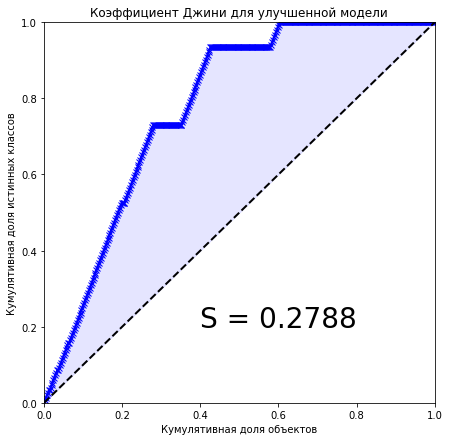

In [18]:
probs_pr = gridsearch_m.predict_proba(np.array(X_test))
predict = [p[1] for p in probs_pr]
actual = Y_test
data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)

x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)

f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=x_values, limit=500)[0] - 0.5
S_actual = quad(f2, 0, 1, points=x_values, limit=500)[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=1, sharey=True, figsize=(7, 7))
ax.plot(x_values, y_values, lw = 2, color = 'blue', marker='x')
ax.fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax.text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
ax.set(title='Коэффициент Джини для улучшенной модели', xlabel='Кумулятивная доля объектов', 
          ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show()

# 4.Посмотрим, есть ли разница без 'Fare'

In [19]:
features_no_fare = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'EmbarkedS', 'EmbarkedQ']
X_train = d_train[features_no_fare]
Y_train = d_train['Survived']
X_test = d_test[features_no_fare]
Y_test = d_test['Survived']

In [20]:
grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [2,5,8],  
    'splitter' : ['random', 'best'],
}
gridsearch_m = GridSearchCV((DecisionTreeClassifier()), grid, cv = 3)     
gridsearch_m.fit(X_train, Y_train)
gridsearch_m.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')

In [21]:
gridsearch_m.best_score_

0.8159371492704826

In [22]:
accuracy_score(y_pred = gridsearch_m.predict(np.array(X_test)), y_true = Y_test)

0.8899521531100478

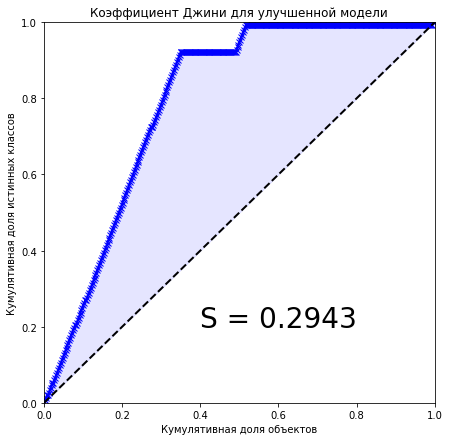

In [23]:
probs_pr = gridsearch_m.predict_proba(np.array(X_test))
predict = [p[1] for p in probs_pr]
actual = Y_test
data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)

x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)

f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=x_values, limit=500)[0] - 0.5
S_actual = quad(f2, 0, 1, points=x_values, limit=500)[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=1, sharey=True, figsize=(7, 7))
ax.plot(x_values, y_values, lw = 2, color = 'blue', marker='x')
ax.fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax.text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
ax.set(title='Коэффициент Джини для улучшенной модели', xlabel='Кумулятивная доля объектов', 
          ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show()

В итоге, лучшая модель, из тех, c которыми я экспериментировала, была с колонками ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'EmbarkedS', 'EmbarkedQ']. Лучшая модель для Титаника: DecisionTreeClassifier(criterion='entropy', max_depth=5, splitter='random').